# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista.

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle('/content/base_nfp (1).pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

In [3]:
data_referencia = pd.to_datetime('2020-01-01')
df_2020 = df.query("`Data Emissão` > @data_referencia").copy()
df_2020

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.0,Liberado,2021,2,0.0,0,não definido
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.0,Liberado,2021,2,0.0,0,Farmácia
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.0,Liberado,2021,2,0.0,0,Mercado


<ipython-input-6-0c3859f8026d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categoria', y='Retorno', data=df_2020.query('Retorno > 0'), palette='viridis')


Text(0.5, 1.0, 'Proporção de Notas com Retorno > 0 por Categoria de Estabelecimento')

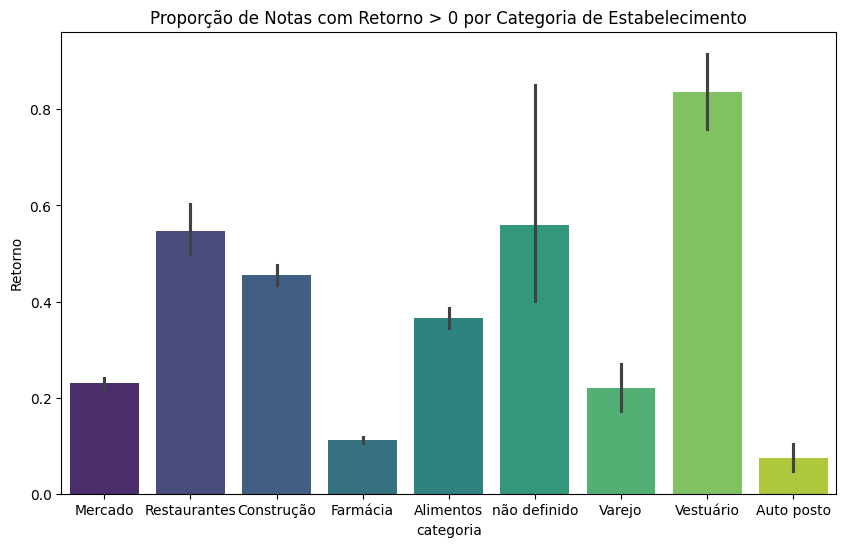

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x='categoria', y='Retorno', data=df_2020.query('Retorno > 0'), palette='viridis')
plt.title('Proporção de Notas com Retorno > 0 por Categoria de Estabelecimento')

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [7]:
df_2020['evento'] = df_2020['Retorno'] > 0
tab = pd.crosstab(df.categoria, df_2020.evento, margins=True, margins_name='total')
tab

evento,False,True,total
categoria,,,
Alimentos,1605,3439,5044
Auto posto,403,135,538
Construção,8523,7522,16045
Farmácia,6601,3582,10183
Mercado,14378,13176,27554
Restaurantes,552,1625,2177
Varejo,4365,701,5066
Vestuário,1477,443,1920
não definido,11717,6688,18405


In [8]:
tab['pct_nao_evento'] = tab[False]/tab.loc['total',False]
tab['pct_evento']     = tab[True]/tab.loc['total',True]
tab

evento,False,True,total,pct_nao_evento,pct_evento
categoria,,,,,
Alimentos,1605,3439,5044,0.032345,0.092171
Auto posto,403,135,538,0.008122,0.003618
Construção,8523,7522,16045,0.171762,0.201603
Farmácia,6601,3582,10183,0.133028,0.096004
Mercado,14378,13176,27554,0.289756,0.353140
Restaurantes,552,1625,2177,0.011124,0.043553
Varejo,4365,701,5066,0.087967,0.018788
Vestuário,1477,443,1920,0.029766,0.011873
não definido,11717,6688,18405,0.236130,0.179250


In [11]:
tab['WOE'] = np.log(tab['pct_evento']/tab['pct_nao_evento'])
tab

evento,False,True,total,pct_nao_evento,pct_evento,WOE
categoria,,,,,,
Alimentos,1605,3439,5044,0.032345,0.092171,1.047183
Auto posto,403,135,538,0.008122,0.003618,-0.808536
Construção,8523,7522,16045,0.171762,0.201603,0.160190
Farmácia,6601,3582,10183,0.133028,0.096004,-0.326174
Mercado,14378,13176,27554,0.289756,0.353140,0.197824
Restaurantes,552,1625,2177,0.011124,0.043553,1.364841
Varejo,4365,701,5066,0.087967,0.018788,-1.543740
Vestuário,1477,443,1920,0.029766,0.011873,-0.919073
não definido,11717,6688,18405,0.236130,0.179250,-0.275600


In [12]:
tab.unstack().WOE.reset_index()

,categoria,0
0,Alimentos,1.047183
1,Auto posto,-0.808536
2,Construção,0.160190
3,Farmácia,-0.326174
4,Mercado,0.197824
5,Restaurantes,1.364841
6,Varejo,-1.543740
7,Vestuário,-0.919073
8,não definido,-0.275600
9,total,0.000000


<ipython-input-13-0ebcda8fbf6e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categoria', y=0, data=tab.unstack().WOE.reset_index(), palette='viridis')


Text(0.5, 1.0, 'WOE por categoria')

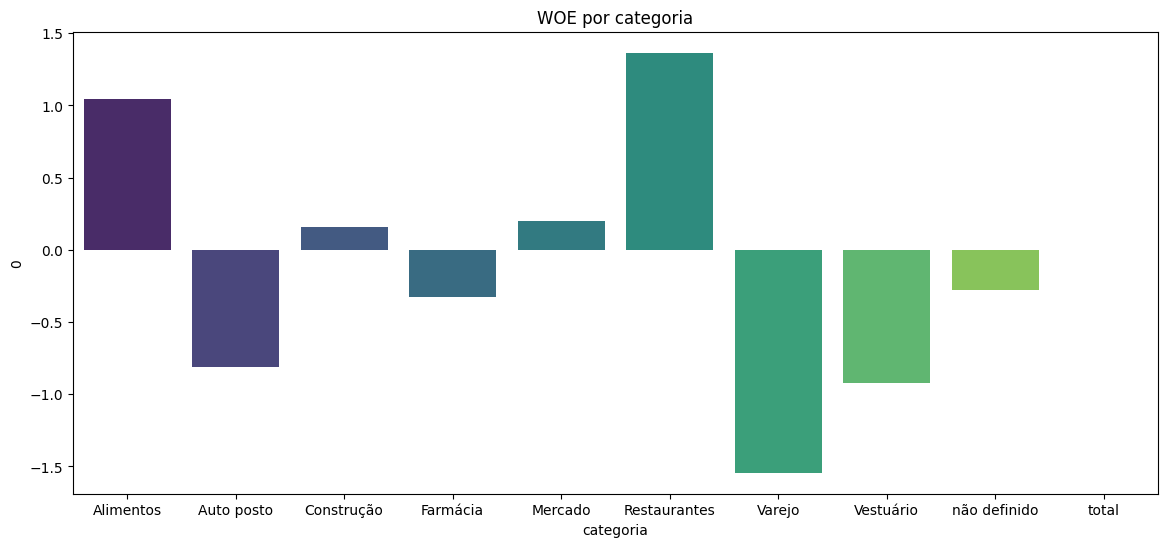

In [13]:
plt.figure(figsize=(14, 6))
sns.barplot(x='categoria', y=0, data=tab.unstack().WOE.reset_index(), palette='viridis')
plt.title('WOE por categoria')

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [16]:
tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.WOE
tab

evento,False,True,total,pct_nao_evento,pct_evento,WOE,iv_parcial
categoria,,,,,,,
Alimentos,1605,3439,5044,0.032345,0.092171,1.047183,0.062649
Auto posto,403,135,538,0.008122,0.003618,-0.808536,0.003641
Construção,8523,7522,16045,0.171762,0.201603,0.160190,0.004780
Farmácia,6601,3582,10183,0.133028,0.096004,-0.326174,0.012076
Mercado,14378,13176,27554,0.289756,0.353140,0.197824,0.012539
Restaurantes,552,1625,2177,0.011124,0.043553,1.364841,0.044260
Varejo,4365,701,5066,0.087967,0.018788,-1.543740,0.106794
Vestuário,1477,443,1920,0.029766,0.011873,-0.919073,0.016444
não definido,11717,6688,18405,0.236130,0.179250,-0.275600,0.015676


In [17]:
((tab.pct_evento - tab.pct_nao_evento)*tab.WOE).sum()

0.27885955236195403

## Conclusao

Essa análise indica que "categoria" possui alguma capacidade de discriminação entre eventos e não eventos, mas não é uma variável que isoladamente forneça uma distinção muito forte. Ela é útil, mas podemos explorar outras variáveis para enriquecer o modelo preditivo.
